# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Wind Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_production_dataset.csv')

data.head()

,Country,Date,Value,Wind10int,Wind100int
0,Australia,2023-03-01,2415.8842,3.689722,5.550105
1,Australia,2023-02-01,2540.7584,3.966472,5.909515
2,Australia,2023-01-01,2614.8241,4.017246,5.866050
3,Australia,2022-12-01,2690.1965,4.128255,6.038626
4,Australia,2022-11-01,2510.9518,4.213749,6.209358


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

wind_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'wind' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Wind10int', 'Wind100int']
    ]
    
    # Store the filtered data in the dictionary
    wind_production_data[country] = country_energy_production.reset_index(drop=True)

wind_production_data["People's Republic of China"]

,Date,Value,Wind10int,Wind100int
0,2023-03-01,83203.5711,2.742932,4.289253
1,2023-02-01,74111.3782,2.651018,4.211082
2,2023-01-01,77258.4283,2.749790,4.422392
3,2022-12-01,81867.4223,2.649647,4.250456
4,2022-11-01,68166.2354,2.611656,4.203430
...,...,...,...,...
94,2015-05-01,17820.9710,2.900405,4.465373
95,2015-04-01,17764.3240,2.931229,4.550757
96,2015-03-01,17435.7750,2.907840,4.599242
97,2015-02-01,12258.2900,2.672918,4.267961


# Resample to daily data

In [4]:
for country_data in wind_production_data:
    
    # set time as the index
    wind_production_data[country_data]['Date'] = pd.to_datetime(wind_production_data[country_data]['Date'])
    wind_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    wind_production_data[country_data]['Value'] = (wind_production_data[country_data]['Value']/
                                                    wind_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = wind_production_data[country_data].resample('D').interpolate('linear')
    wind_production_data[country_data] = daily_data
    
wind_production_data["People's Republic of China"]

,Value,Wind10int,Wind100int
Date,,,
2015-01-01,487.890323,2.463587,3.996645
2015-01-02,486.274379,2.470340,4.005397
2015-01-03,484.658435,2.477092,4.014149
2015-01-04,483.042492,2.483845,4.022901
2015-01-05,481.426548,2.490598,4.031653
...,...,...,...
2023-02-25,2678.678846,2.729801,4.278086
2023-02-26,2680.005676,2.733084,4.280877
2023-02-27,2681.332505,2.736367,4.283669


# Model Building

### Split train and test data

In [5]:
data = wind_production_data["People's Republic of China"]

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                 Value  Wind10int  Wind100int
Date                                         
2015-01-01  487.890323   2.463587    3.996645
2015-01-02  486.274379   2.470340    4.005397
2015-01-03  484.658435   2.477092    4.014149
2015-01-04  483.042492   2.483845    4.022901
2015-01-05  481.426548   2.490598    4.031653
(2193, 3)

                  Value  Wind10int  Wind100int
Date                                          
2021-01-01  1407.413216   2.726627    4.390449
2021-01-02  1431.047032   2.726307    4.387759
2021-01-03  1454.680848   2.725986    4.385069
2021-01-04  1478.314664   2.725666    4.382379
2021-01-05  1501.948480   2.725346    4.379690
(790, 3)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (2,1,2)(0,1,0)[365] 

#### Figure below show the result from R:
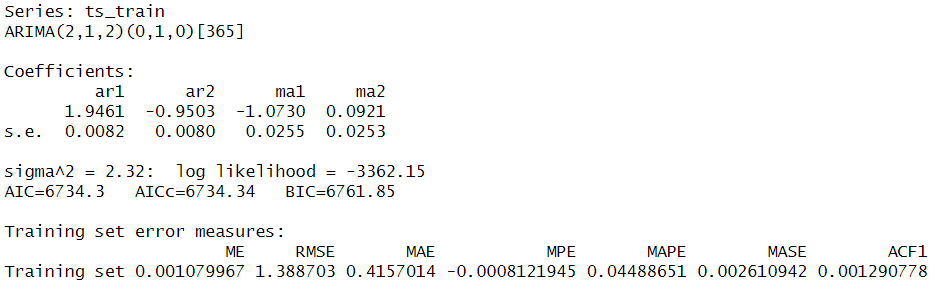

In [56]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
chn_wind_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\chn_wind_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [58]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(chn_wind_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  331.73885582535354
Mean Squared Error:  161638.671595231
Root Mean Squared Error:  402.0431215618929


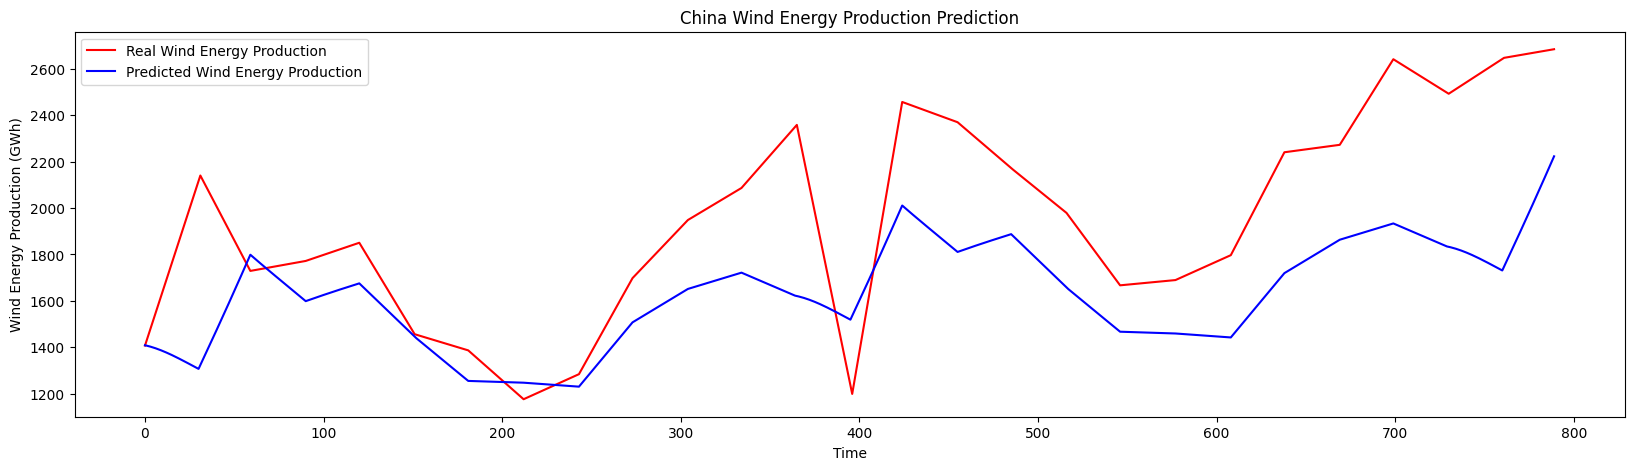

In [59]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('China Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [60]:
def create_features(df, label=None):

    #Creates time series features from datetime index
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [61]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2015-01-01          3        1      1  2015          1           1           1
2015-01-02          4        1      1  2015          2           2           1
2015-01-03          5        1      1  2015          3           3           1
2015-01-04          6        1      1  2015          4           4           1
2015-01-05          0        1      1  2015          5           5           2
(2193, 7)

Date
2015-01-01    487.890323
2015-01-02    486.274379
2015-01-03    484.658435
2015-01-04    483.042492
2015-01-05    481.426548
Freq: D, Name: Value, dtype: float64
(2193,)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2021-01-01          4        1      1  2021          1           1          53
2021-01-02          5  

In [12]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [13]:
chn_daily_xgb = xgb.XGBRegressor(n_estimators=1000)
chn_daily_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:662.96890	validation_1-rmse:1610.34519
[1]	validation_0-rmse:467.80125	validation_1-rmse:1350.22088
[2]	validation_0-rmse:330.12599	validation_1-rmse:1174.97018
[3]	validation_0-rmse:233.73948	validation_1-rmse:1045.94861
[4]	validation_0-rmse:165.80024	validation_1-rmse:956.46097
[5]	validation_0-rmse:118.03340	validation_1-rmse:897.61904
[6]	validation_0-rmse:84.69758	validation_1-rmse:853.01299
[7]	validation_0-rmse:61.53515	validation_1-rmse:822.03003
[8]	validation_0-rmse:45.31475	validation_1-rmse:800.36885
[9]	validation_0-rmse:34.31205	validation_1-rmse:785.15200
[10]	validation_0-rmse:26.63467	validation_1-rmse:774.40592
[11]	validation_0-rmse:21.12535	validation_1-rmse:767.18920
[12]	validation_0-rmse:17.35832	validation_1-rmse:761.47513
[13]	validation_0-rmse:14.85488	validation_1-rmse:757.37409
[14]	validation_0-rmse:13.31361	validation_1-rmse:754.69406
[15]	validation_0-rmse:12.41235	validation_1-rmse:752.97019
[16]	validation_0-rmse:11.60565	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

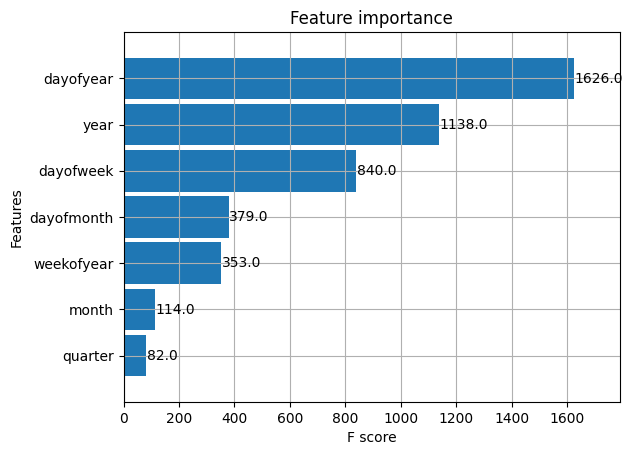

In [14]:
_ = plot_importance(chn_daily_xgb, height=0.9)

In [62]:
xgb_y_pred = chn_daily_xgb.predict(X_test)

In [63]:
print("Mean Absolute Error: ", mean_absolute_error(xgb_y_pred, test['Value'].values))
mse = mean_squared_error(xgb_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  665.6680299440599
Mean Squared Error:  558968.3108629915
Root Mean Squared Error:  747.6418332751261


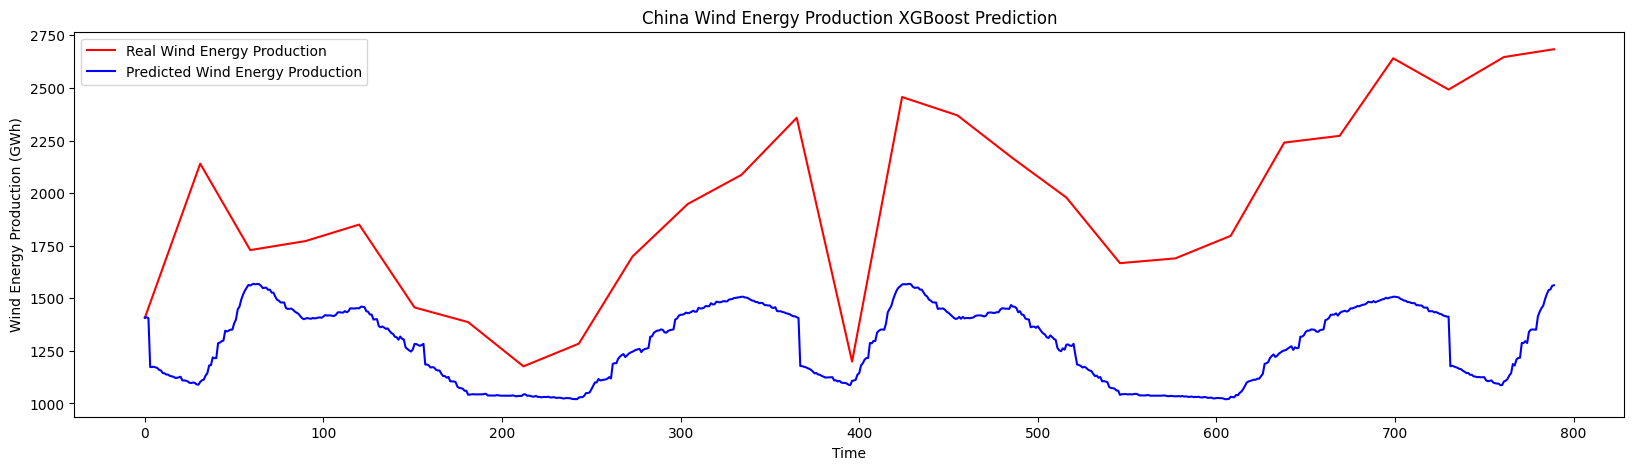

In [64]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(xgb_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('China Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [65]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(1828, 365) (1828,)


In [66]:
# Build and Train the SVM Model
chn_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01) # Specify hyperparameters
chn_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [68]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Wind Energy Production
svr_y_pred = chn_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [69]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  19.402839789032413
Mean Squared Error:  599.7587482562272
Root Mean Squared Error:  24.489972402112404


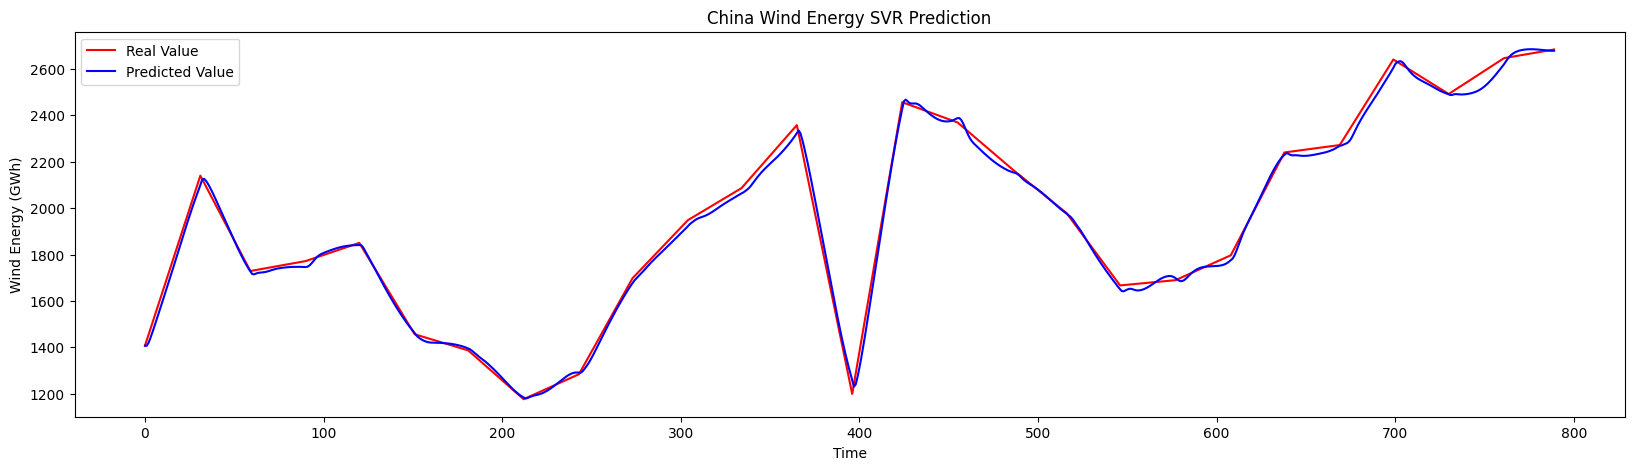

In [70]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('China Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [24]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [25]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [26]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
chn_daily_gru = Sequential()
chn_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
chn_daily_gru.add(GRU(units=64, input_shape=(time_steps, 1)))
chn_daily_gru.add(Dense(1, activation='linear'))

chn_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
chn_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 95s 622ms/step - loss: 0.0257
Epoch 2/100
58/58 [==============================] - 37s 642ms/step - loss: 2.3621e-04
Epoch 3/100
58/58 [==============================] - 37s 637ms/step - loss: 1.3654e-04
Epoch 4/100
58/58 [==============================] - 34s 592ms/step - loss: 1.1482e-04
Epoch 5/100
58/58 [==============================] - 36s 615ms/step - loss: 1.0059e-04
Epoch 6/100
58/58 [==============================] - 37s 641ms/step - loss: 8.9647e-05
Epoch 7/100
58/58 [==============================] - 36s 618ms/step - loss: 8.1171e-05
Epoch 8/100
58/58 [==============================] - 37s 640ms/step - loss: 7.2276e-05
Epoch 9/100
58/58 [==============================] - 38s 648ms/step - loss: 6.6122e-05
Epoch 10/100
58/58 [==============================] - 35s 610ms/step - loss: 6.3985e-05
Epoch 11/100
58/58 [==============================] - 37s 640ms/step - loss: 5.8360e-05
Epoch 12/100
58/58 [=========================

In [28]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = chn_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 17s 124ms/step


In [29]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.185008525281084
Mean Squared Error:  46.55435919027376
Root Mean Squared Error:  6.823075493520041


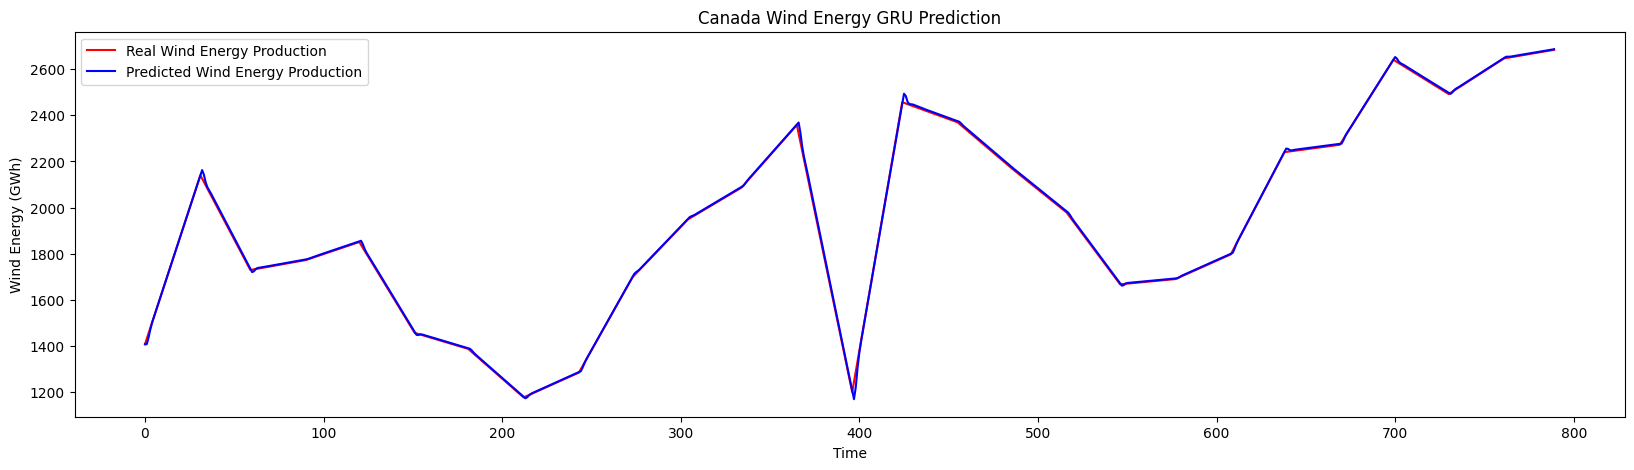

In [30]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('China Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [31]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.08822009]
 [0.08688876]
 [0.08555743]
 ...
 [0.85122663]
 [0.84850727]
 [0.84578792]]
(2193, 1)


In [32]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [33]:
print(X_train)
X_train.shape

[[0.08822009 0.08688876 0.08555743 ... 0.18074678 0.1817716  0.18279643]
 [0.08688876 0.08555743 0.0842261  ... 0.1817716  0.18279643 0.18382125]
 [0.08555743 0.0842261  0.08289477 ... 0.18279643 0.18382125 0.18070485]
 ...
 [0.65888899 0.65495564 0.65252277 ... 0.8593847  0.85666534 0.85394599]
 [0.65495564 0.65252277 0.65008991 ... 0.85666534 0.85394599 0.85122663]
 [0.65252277 0.65008991 0.64765704 ... 0.85394599 0.85122663 0.84850727]]


(1828, 365)

In [34]:
print(y_train)
y_train.shape

[0.18382125 0.18070485 0.17758845 ... 0.85122663 0.84850727 0.84578792]


(1828,)

In [35]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [37]:
# Initialising the RNN
chn_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
chn_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
chn_daily_uni_lstm.add(Dropout(0.2))

chn_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
chn_daily_uni_lstm.add(Dropout(0.2))

chn_daily_uni_lstm.add(LSTM(units = 64))
chn_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
chn_daily_uni_lstm.add(Dense(units = 1))

In [38]:
# Compiling the RNN
chn_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
chn_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 148s 910ms/step - loss: 0.0188
Epoch 2/100
58/58 [==============================] - 41s 698ms/step - loss: 0.0039
Epoch 3/100
58/58 [==============================] - 41s 707ms/step - loss: 0.0037
Epoch 4/100
58/58 [==============================] - 39s 665ms/step - loss: 0.0033
Epoch 5/100
58/58 [==============================] - 30s 511ms/step - loss: 0.0028
Epoch 6/100
58/58 [==============================] - 38s 653ms/step - loss: 0.0027
Epoch 7/100
58/58 [==============================] - 40s 697ms/step - loss: 0.0027
Epoch 8/100
58/58 [==============================] - 42s 725ms/step - loss: 0.0023
Epoch 9/100
58/58 [==============================] - 45s 776ms/step - loss: 0.0021
Epoch 10/100
58/58 [==============================] - 44s 754ms/step - loss: 0.0019
Epoch 11/100
58/58 [==============================] - 43s 742ms/step - loss: 0.0020
Epoch 12/100
58/58 [==============================] - 43s 748ms/step - loss: 0.0017


In [39]:
test[['Value']].shape

(790, 1)

In [76]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = chn_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 25s 168ms/step


In [77]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  64.67034540040409
Mean Squared Error:  8907.43963996191
Root Mean Squared Error:  94.3792330969155


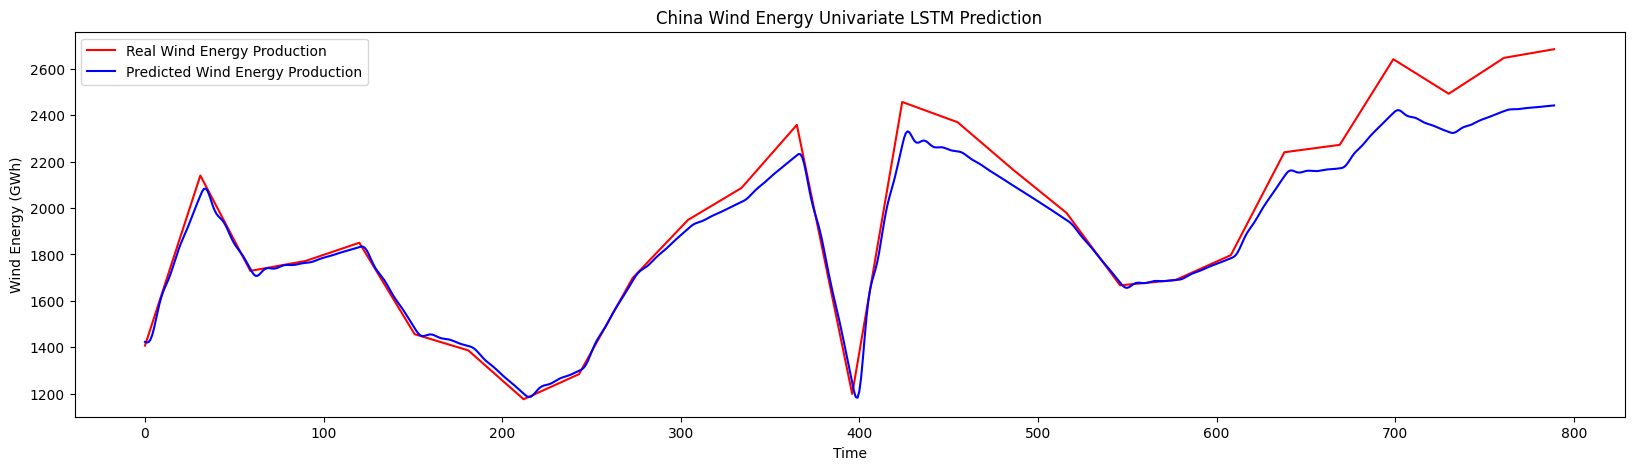

In [78]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('China Wind Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [80]:
data = wind_production_data["People's Republic of China"]

data.shape

(2982, 3)

In [81]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2015-01-01,2.463587,3.996645,487.890323
2015-01-02,2.470340,4.005397,486.274379
2015-01-03,2.477092,4.014149,484.658435
2015-01-04,2.483845,4.022901,483.042492
2015-01-05,2.490598,4.031653,481.426548


In [82]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [83]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [47]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2193, 3)
(790, 3)

(2193, 1)
(790, 1)


In [84]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(1828, 365, 3)


In [85]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [50]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

chn_daily_multi_lstm = Sequential()
chn_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(LSTM(units = 64))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(Dense(1))

In [51]:
chn_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

chn_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 187s 888ms/step - loss: 0.0209
Epoch 2/100
58/58 [==============================] - 52s 905ms/step - loss: 0.0038
Epoch 3/100
58/58 [==============================] - 50s 868ms/step - loss: 0.0032
Epoch 4/100
58/58 [==============================] - 50s 867ms/step - loss: 0.0029
Epoch 5/100
58/58 [==============================] - 51s 883ms/step - loss: 0.0030
Epoch 6/100
58/58 [==============================] - 55s 937ms/step - loss: 0.0028
Epoch 7/100
58/58 [==============================] - 50s 861ms/step - loss: 0.0028
Epoch 8/100
58/58 [==============================] - 49s 841ms/step - loss: 0.0024
Epoch 9/100
58/58 [==============================] - 52s 888ms/step - loss: 0.0022
Epoch 10/100
58/58 [==============================] - 51s 873ms/step - loss: 0.0021
Epoch 11/100
58/58 [==============================] - 51s 882ms/step - loss: 0.0021
Epoch 12/100
58/58 [==============================] - 52s 890ms/step - loss: 0.0023


58/58 [==============================] - 39s 667ms/step - loss: 4.3466e-04
Epoch 97/100
58/58 [==============================] - 39s 669ms/step - loss: 4.5130e-04
Epoch 98/100
58/58 [==============================] - 43s 749ms/step - loss: 5.8379e-04
Epoch 99/100
58/58 [==============================] - 44s 762ms/step - loss: 5.2772e-04
Epoch 100/100
58/58 [==============================] - 46s 799ms/step - loss: 4.8604e-04


In [86]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
multi_lstm_y_pred = chn_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 3)
25/25 [==============================] - 22s 250ms/step


array([[1404.6342],
       [1402.7842],
       [1402.0079],
       [1403.8115],
       [1409.4622],
       [1419.6996],
       [1434.6532],
       [1453.901 ],
       [1476.6057],
       [1501.6879],
       [1528.0215],
       [1554.5905],
       [1580.5775],
       [1605.3992],
       [1628.6958],
       [1650.2994],
       [1670.1888],
       [1688.446 ],
       [1705.2183],
       [1720.6853],
       [1735.0381],
       [1748.4558],
       [1761.1138],
       [1773.163 ],
       [1784.7196],
       [1795.881 ],
       [1806.7213],
       [1817.2932],
       [1827.6311],
       [1837.754 ],
       [1847.6676],
       [1857.3684],
       [1866.8441],
       [1875.5884],
       [1882.7639],
       [1887.8124],
       [1890.4552],
       [1890.6398],
       [1888.4806],
       [1884.2156],
       [1878.1333],
       [1870.5331],
       [1861.7137],
       [1851.9095],
       [1841.3551],
       [1830.2915],
       [1818.8904],
       [1807.21  ],
       [1795.3718],
       [1783.4729],


In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  213.75679078204527
Mean Squared Error:  83769.36414764533
Root Mean Squared Error:  289.4293767875772


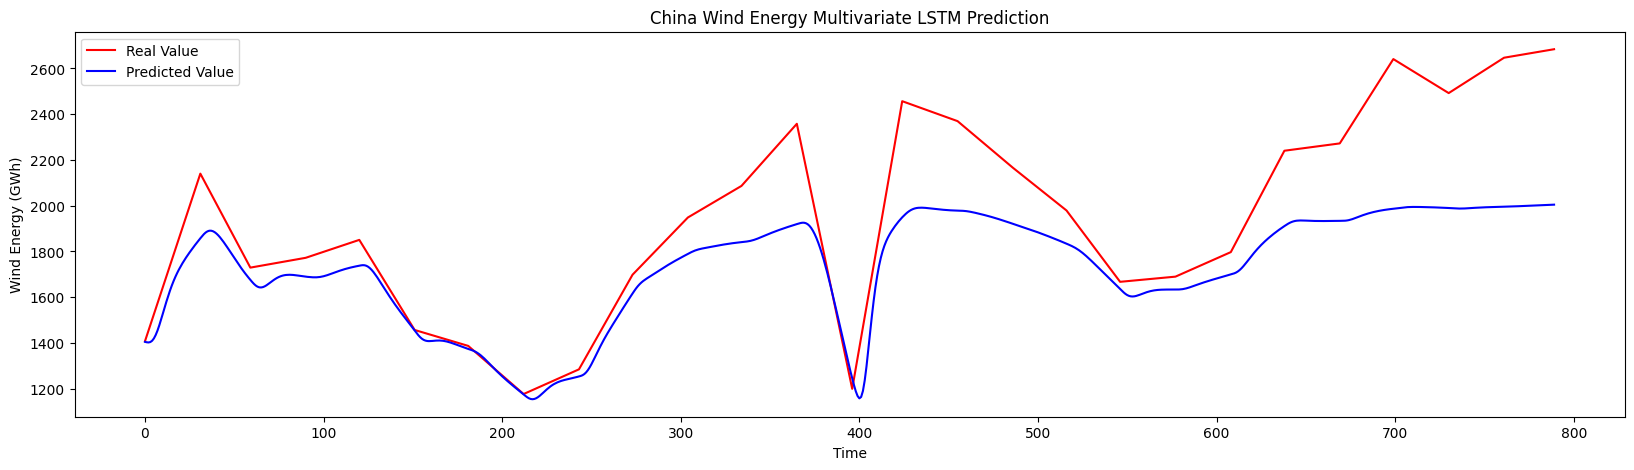

In [88]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('China Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

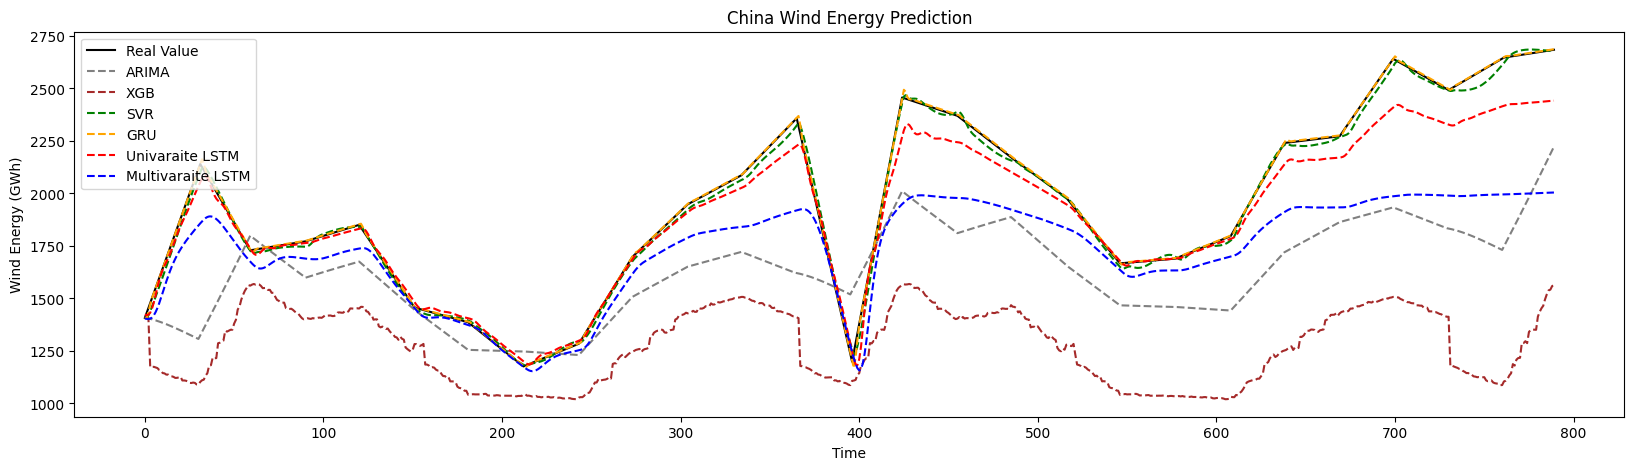

In [90]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(xgb_y_pred, color='brown', linestyle='--', label='XGB')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('China Wind Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [55]:
chn_daily_gru.save("chn_wind_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
